In [2]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pypinyin import lazy_pinyin
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

# Step 1: Change the working directory (update the path accordingly)
new_dir = "C:/Users/Andy/Documents/stock/"
os.chdir(new_dir)


C:\Users\Andy\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
df = pd.read_csv("Trim_train/merged_cleaned_data.csv")

In [6]:
from googletrans import Translator
import pandas as pd

# Initialize translator
translator = Translator()

# Translate column names
translated_columns = {col: translator.translate(col, src='zh-TW', dest='en').text for col in df.columns}

# Rename dataframe columns
df.rename(columns=translated_columns, inplace=True)

# Print some translations for verification
print(translated_columns)

{'ID': 'ID', '外資券商_分點進出': 'Foreign securities firms_In and out at every point', '外資券商_分點成交力(%)': 'Foreign securities firm_point trading power (%)', '外資券商_分點吃貨比(%)': 'Foreign securities firms_Second foodie ratio (%)', '外資券商_分點出貨比(%)': 'Foreign securities firms_Point shipment ratio (%)', '外資券商_前1天分點進出': 'Foreign securities firms_In and exit at the first 1 day', '外資券商_前1天分點成交力(%)': 'Foreign securities firm_Trading power in the first 1 day (%)', '外資券商_前1天分點吃貨比(%)': 'Foreign securities firms_Foodies comparison in the first day (%)', '外資券商_前1天分點出貨比(%)': 'Foreign securities firms_Shipping ratio in the first 1 day (%)', '外資券商_前2天分點進出': 'Foreign securities firms_In and exit in the first 2 days', '外資券商_前2天分點成交力(%)': 'Foreign securities firm_Trading power in the first 2 days (%)', '外資券商_前2天分點吃貨比(%)': 'Foreign securities firms_Foodies comparison in the first two days (%)', '外資券商_前2天分點出貨比(%)': 'Foreign securities firms_Shipping ratio in the first two days (%)', '外資券商_前3天分點進出': 'Foreign securities f

In [1]:
# Set Pandas to display all columns
pd.set_option('display.max_columns', None)

df.head()

NameError: name 'pd' is not defined

In [28]:
rolling_windows = [5, 10, 20]

for window in rolling_windows:
    df[f'price_ma_{window}'] = df['Closed price of individual stocks'].rolling(window).mean()
    df[f'vol_ma_{window}'] = df['Stock trading volume'].rolling(window).mean()
    df[f'vol_std_{window}'] = df['Stock trading volume'].rolling(window).std()

In [29]:
# Extract relevant columns (ensure column names match your dataset)
closing_price_col = "Closed price of individual stocks"  # Adjust if needed
trading_volume_col = "Stock trading volume"  # Adjust if needed


In [30]:
# Daily Returns
df['daily_return'] = df[closing_price_col].pct_change()


In [32]:
df[closing_price_col]

0         1.0543
1         1.2712
2         6.0341
3         1.2969
4         0.8969
           ...  
200859    1.0211
200860    1.8369
200861    0.8792
200862    0.8621
200863    1.4076
Name: Closed price of individual stocks, Length: 200864, dtype: float64

In [31]:
df['daily_return']

0              NaN
1         0.205729
2         3.746775
3        -0.785072
4        -0.308428
            ...   
200859    0.201577
200860    0.798942
200861   -0.521368
200862   -0.019449
200863    0.632757
Name: daily_return, Length: 200864, dtype: float64

In [26]:
df['price_ma_5'] = df['Closed price of individual stocks in the previous day'].rolling(5).mean()
df['vol_ma_5'] = df['Stock trading volume'].rolling(5).mean()

KeyError: 'Closed price of individual stocks in the previous day'

In [112]:
print(df.columns.tolist())

['ID', 'Foreign securities firms_In and out at every point', 'Foreign securities firm_point trading power (%)', 'Foreign securities firms_Second foodie ratio (%)', 'Foreign securities firms_Point shipment ratio (%)', 'Foreign securities firms_In and exit at the first 1 day', 'Foreign securities firm_Trading power in the first 1 day (%)', 'Foreign securities firms_Foodies comparison in the first day (%)', 'Foreign securities firms_Shipping ratio in the first 1 day (%)', 'Foreign securities firms_In and exit in the first 2 days', 'Foreign securities firm_Trading power in the first 2 days (%)', 'Foreign securities firms_Foodies comparison in the first two days (%)', 'Foreign securities firms_Shipping ratio in the first two days (%)', 'Foreign securities firms_In and exit in the first 3 days', 'Foreign securities firm_Trading power in the first 3 days (%)', 'Foreign securities firms_Foodies comparison in the first 3 days (%)', 'Foreign securities firms_Shipping ratio in the first 3 days (%

In [7]:
arguments = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "num_leaves": 20,
    "learning_rate": 0.1034,
    "n_estimators": 3000,
    "max_bin": 113,
    "subsample": 0.7708753433144212,
    "subsample_freq": 5,
    "colsample_bytree": 0.6628,
    "feature_fraction_seed": 42,
    "bagging_seed": 42,
    "min_child_samples": 25
}

In [8]:
target_column = "Storm stocks" 

In [131]:
X = df.drop(columns=[target_column, "ID"], errors="ignore")
y = df[target_column]

In [111]:
import unicodedata
import re
def clean_feature_name(name):
    """Clean non-ASCII characters and special symbols in column names."""
    # Normalize to remove hidden Unicode characters
    name = unicodedata.normalize('NFKD', name)
    
    # Remove non-ASCII characters
    name = name.encode('ascii', 'ignore').decode()
    
    # Replace special characters (%, spaces, etc.) with underscores
    name = re.sub(r'[^a-zA-Z0-9_]', '_', name)
    
    # Replace multiple underscores with a single one
    name = re.sub(r'__+', '_', name).strip('_')

    return name


In [132]:
X.columns = [clean_feature_name(col) for col in X.columns]

## Outliers

In [95]:
X.shape

(200864, 679)

In [61]:
from scipy.stats import zscore
z_scores = np.abs(zscore(X.select_dtypes(include=[np.number]), nan_policy='omit'))

# Flag any row with at least one feature where Z-score > threshold (commonly 3)
outlier_rows = (z_scores > 3).any(axis=1)

# Get outlier and non-outlier subsets
X_outliers = X[outlier_rows]
X_non_outliers = X[~outlier_rows]

# Match y values
y_outliers = y[outlier_rows]
y_non_outliers = y[~outlier_rows]

In [62]:
print("Outlier y value counts:")
print(y_outliers.value_counts(normalize=True))

print("\nNon-Outlier y value counts:")
print(y_non_outliers.value_counts(normalize=True))

Outlier y value counts:
0    0.991291
1    0.008709
Name: Storm stocks, dtype: float64

Non-Outlier y value counts:
0    0.996486
1    0.003514
Name: Storm stocks, dtype: float64


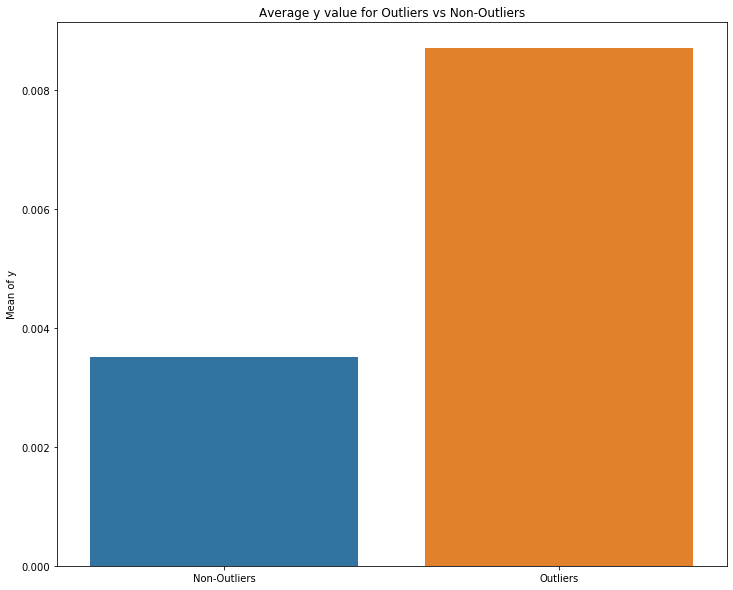

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.barplot(x=['Non-Outliers', 'Outliers'], y=[y_non_outliers.mean(), y_outliers.mean()])
plt.ylabel('Mean of y')
plt.title('Average y value for Outliers vs Non-Outliers')
plt.show()

In [119]:
quantiles = [0.95]

for q in quantiles:
    upper = X.quantile(q)
    lower = X.quantile(1 - q)
    
    # Create boolean masks
    upper_mask = (X > upper)
    lower_mask = (X < lower)

    # Add binary columns
    X[f"upper_outlier_{int(q*100)}"] = upper_mask.any(axis=1).astype(int)
    X[f"lower_outlier_{int(q*100)}"] = lower_mask.any(axis=1).astype(int)

    # Optional: count of how many features are upper/lower outliers
    X[f"upper_outlier_count_{int(q*100)}"] = upper_mask.sum(axis=1)
    X[f"lower_outlier_count_{int(q*100)}"] = lower_mask.sum(axis=1)



C:\Users\Andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [120]:
# Get the outlier count columns you want to scale
outlier_cols = [col for col in X.columns if "outlier_count" in col and "scaled" not in col]

# Scale them
scaled_outliers = scaler.fit_transform(X[outlier_cols])

# Convert to DataFrame with correct column names
scaled_df = pd.DataFrame(scaled_outliers, columns=[f"{col}_scaled" for col in outlier_cols], index=X.index)

# Join back to X
X = pd.concat([X, scaled_df], axis=1)


In [133]:
# Calculate IQR for all numerical features
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Define outliers: Any value outside 1.5 * IQR bounds
outlier_mask = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Create an "outlier count" column (number of outlier features per row)
X["outlier_count"] = outlier_mask.sum(axis=1)

# Optional: Convert to binary flag (1 if any outlier, 0 if none)
X["is_outlier"] = (X["outlier_count"] > 0).astype(int)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X["outlier_count_scaled"] = scaler.fit_transform(X[["outlier_count"]])

C:\Users\Andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [134]:
X = X.fillna(X.mean())

C:\Users\Andy\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\Andy\Anaconda3\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [126]:
# Calculate IQR for all numerical features
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Define outliers: Any value outside 1.5 * IQR bounds
outlier_mask = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Create an "outlier count" column (number of outlier features per row)
X["outlier_count"] = outlier_mask.sum(axis=1)

# Optional: Convert to binary flag (1 if any outlier, 0 if none)
X["is_outlier"] = (X["outlier_count"] > 0).astype(int)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X["outlier_count_scaled"] = scaler.fit_transform(X[["outlier_count"]])

In [135]:
X.shape

(200864, 674)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [137]:
bigModel = lgb.LGBMClassifier(**arguments)
bigModel.fit(X_train, y_train)

# Step 6: Predict and Evaluate Accuracy
y_pred_proba = bigModel.predict_proba(X_test)[:, 1]  # Get probability for class 1

In [140]:
y_pred = (y_pred_proba >= 0.3).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.849515
Recall: 0.595238
F1 Score: 0.7000


In [139]:
# after spliting outliers in 2 direction
y_pred = (y_pred_proba >= 0.4).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.940000
Recall: 0.479592
F1 Score: 0.6351


## Normalization

In [81]:
stats = X.describe().T[['mean', 'std']]
not_normalized = stats[(stats['mean'].abs() > 1e-2) | (stats['std'] > 1.1) | (stats['std'] < 0.9)]
print("Columns that are likely NOT normalized:")
print(not_normalized)

Columns that are likely NOT normalized:
                                                         mean        std
Foreign_securities_firms_In_and_out_at_every_point   1.223706   1.006675
Foreign_securities_firm_point_trading_power          1.221375   0.991976
Foreign_securities_firms_Second_foodie_ratio         1.221701   0.993638
Foreign_securities_firms_Point_shipment_ratio        1.221942   0.994027
Foreign_securities_firms_In_and_exit_at_the_fir...   1.221205   1.011736
...                                                       ...        ...
Listing_weighted_index_10_day_trading_volume_vo...   1.220630   1.000325
Listing_weighted_index_20_day_trading_volume_vo...   1.220340   0.998925
is_outlier                                           0.999975   0.004989
outlier_count_scaled                                 0.193175   0.150612
outlier_count                                       65.682935  51.556169

[674 rows x 2 columns]


## Technical indicator

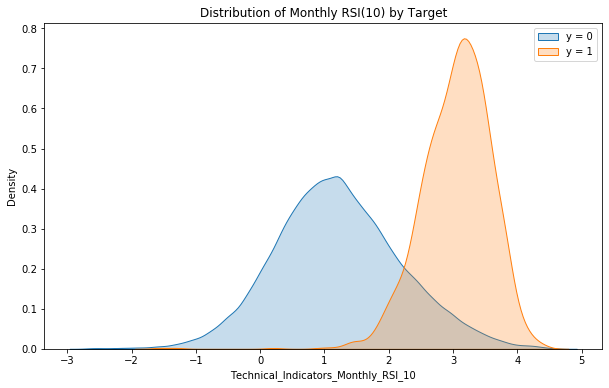

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(X[y == 0]['Technical_Indicators_Monthly_RSI_10'], label='y = 0', fill=True)
sns.kdeplot(X[y == 1]['Technical_Indicators_Monthly_RSI_10'], label='y = 1', fill=True)
plt.title('Distribution of Monthly RSI(10) by Target')
plt.xlabel('Technical_Indicators_Monthly_RSI_10')
plt.ylabel('Density')
plt.legend()
plt.show()

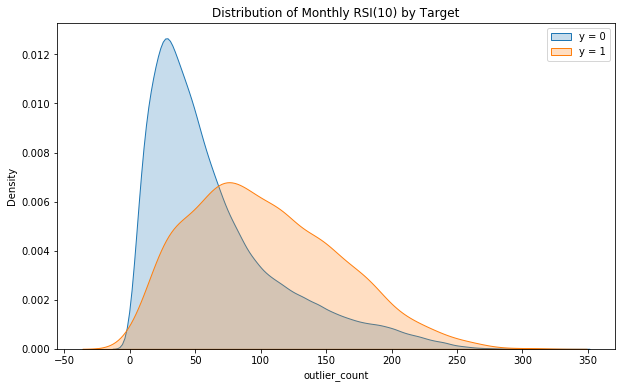

In [142]:
plt.figure(figsize=(10, 6))
sns.kdeplot(X[y == 0]['outlier_count'], label='y = 0', fill=True)
sns.kdeplot(X[y == 1]['outlier_count'], label='y = 1', fill=True)
plt.title('Distribution of Monthly RSI(10) by Target')
plt.xlabel('outlier_count')
plt.ylabel('Density')
plt.legend()
plt.show()

In [83]:
from scipy.stats import wasserstein_distance

# Assuming X and y are already defined
feature_distances = {}

for col in X.columns:
    try:
        class_0 = X[y == 0][col].dropna()
        class_1 = X[y == 1][col].dropna()
        distance = wasserstein_distance(class_0, class_1)
        feature_distances[col] = distance
    except Exception as e:
        print(f"Could not process {col}: {e}")

# Sort and show top 5 features with highest distance
top_diff_features = sorted(feature_distances.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 features with largest distribution difference between y=0 and y=1:\n")
for feature, dist in top_diff_features:
    print(f"{feature}: Wasserstein Distance = {dist:.4f}")

Top 5 features with largest distribution difference between y=0 and y=1:

outlier_count: Wasserstein Distance = 38.1862
Technical_indicators_Disagreement_rate_250_days: Wasserstein Distance = 2.0294
Technical_indicators_Disagreement_rate_60_days: Wasserstein Distance = 1.8945
Technical_Indicators_Monthly_RSI_10: Wasserstein Distance = 1.8389
19_day_deviation_rate_of_individual_stocks: Wasserstein Distance = 1.8037


## Trading volume

In [86]:
trading_volume_cols = [col for col in X.columns if 'Trading_volume' in col]
print("Columns containing 'Trading_volume':")
for col in trading_volume_cols:
    print(col)

Columns containing 'Trading_volume':
Trading_volume_of_individual_stocks_in_the_first_day
Trading_volume_of_individual_stocks_in_the_first_two_days
Trading_volume_of_individual_stocks_in_the_first_3_days
Trading_volume_in_the_first_4_days_of_individual_stocks
Trading_volume_of_individual_stocks_in_the_first_5_days
Trading_volume_of_individual_stocks_in_the_first_6_days
Trading_volume_of_individual_stocks_in_the_first_7_days
Trading_volume_of_individual_stocks_in_the_first_8_days
Trading_volume_of_individual_stocks_in_the_first_9_days
Trading_volume_in_the_first_10_days_of_individual_stocks
Trading_volume_in_the_first_11_days_of_individual_stocks
Trading_volume_in_the_first_12_days_of_individual_stocks
Trading_volume_in_the_first_13_days_of_individual_stocks
Trading_volume_in_the_first_14_days_of_individual_stocks
Trading_volume_in_the_first_15_days_of_individual_stocks
Trading_volume_of_individual_stocks_in_the_first_16_days
Trading_volume_in_the_first_17_days_of_individual_stocks
Trad

## missing values

### Original

In [57]:
X.shape

(200864, 671)

In [58]:
# Count missing values per column
missing_values = X.isna().sum()

# Print only columns with missing values
missing_values = missing_values[missing_values > 0]
print(missing_values)

Foreign_securities_firm_point_trading_power                     2374
Foreign_securities_firms_Second_foodie_ratio                    2374
Foreign_securities_firms_Point_shipment_ratio                   2374
Foreign_securities_firm_Trading_power_in_the_first_1_day        2311
Foreign_securities_firms_Foodies_comparison_in_the_first_day    2311
                                                                ... 
Quarterly_IFRS_financial_report_Quarterly_closing_price_yuan     907
Quarterly_IFRS_Financial_Report_DPZ_Score                       5026
Quarterly_IFRS_Financial_Report_DPZ_Level                       5026
Quarterly_IFRS_Financial_Report_Z_Score                         5956
Quarterly_IFRS_Financial_Report_Z_Level                         5956
Length: 449, dtype: int64


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
bigModel = lgb.LGBMClassifier(**arguments)
bigModel.fit(X_train, y_train)

# Step 6: Predict and Evaluate Accuracy
y_pred_proba = bigModel.predict_proba(X_test)[:, 1]  # Get probability for class 1

In [21]:
y_pred = (y_pred_proba >= 0.3).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.839623
Recall: 0.605442
F1 Score: 0.7036


In [38]:
dupe_cols = X.columns[X.columns.duplicated()]
print("Duplicate Columns:", dupe_cols.tolist())

Duplicate Columns: ['Technical_Indicators_Quarter_DI_14', 'Technical_Indicators_DI_14', 'Technical_Indicators_DM_14', 'Technical_indicators_monthly_DM_14', 'Quarterly_IFRS_financial_report_After_tax_return_rate_cumulative_quarterly', 'Quarterly_IFRS_Financial_Report_Original_Cash_Flow_per_Share_yuan']


In [39]:
X.columns = [f"{col}_{i}" if X.columns.duplicated()[i] else col for i, col in enumerate(X.columns)]

In [52]:
X_filled_mean = X.fillna(X.mean())

In [53]:
missing_values = X_filled_mean.isna().sum()

# Print only columns with missing values
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_filled_mean, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
bigModel = lgb.LGBMClassifier(**arguments)
bigModel.fit(X_train, y_train)

# Step 6: Predict and Evaluate Accuracy
y_pred_proba = bigModel.predict_proba(X_test)[:, 1]  # Get probability for class 1

In [56]:
y_pred = (y_pred_proba >= 0.3).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.837209
Recall: 0.612245
F1 Score: 0.7073


In [56]:
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": bigModel.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

# Keep only top 200 most important features
top_features = feature_importance.head(200)["feature"].tolist()

In [57]:
top_features

['Technical_Indicators_Monthly_RSI_10',
 'Technical_indicators_Monthly_RSI_5',
 'Technical_indicators_Journey_K_9',
 'Technical_Indicators_Jing_RSI_10',
 'Technical_Indicators_Alpha_250D',
 'Technical_indicators_Quest_D_9',
 'Technical_Indicators_Zhou_RSI_5',
 'Technical_indicators_Disagreement_rate_250_days',
 'Technical_Indicators_Quarterly_RSI_5',
 'Technical_Indicators_Monthly_ADX_14',
 'Technical_Indicators_RSI_10',
 'Technical_indicators_relative_strength_ratio_weekly',
 'Technical_indicators_Monthly_K_9',
 'Technical_indicators_monthly_DI_14',
 'Technical_indicators_month_DI_14',
 'Technical_indicators_Monthly_D_9',
 'Technical_Indicators_Week_DI_14',
 '5_day_return_rate_for_individual_stocks',
 'Technical_Indicators_Quarterly_RSI_10',
 '10_day_deviation_rate_of_individual_stocks',
 'Technical_Indicators_RSI_5',
 'Technical_Indicators_Jing_DI_14',
 'Technical_Indicators_DI_14',
 'Technical_Indicators_Quest_ADX_14',
 'Technical_indicators_Disagreement_rate_20_days',
 'Listing_wei

In [55]:
y_pred = (y_pred_proba >= 0.3).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.809302
Recall: 0.591837
F1 Score: 0.6837


### Feature engineering 

In [58]:
# Feature 1: Momentum-based RSI signal
X['RSI_Trend'] = X['Technical_Indicators_Monthly_RSI_10'] - X['Technical_indicators_Monthly_RSI_5']

# Feature 2: Volatility Spread (Long-term vs Short-term)
X['Volatility_Trend'] = X['vol_std_20'] - X['5_day_deviation_rate_of_individual_stocks']

# Feature 3: Return Rate Acceleration
X['Return_Acceleration'] = X['10_day_return_rate_for_individual_stocks'] - X['5_day_return_rate_for_individual_stocks']

# Feature 4: Index vs. Stock Return Difference
X['Index_vs_Stock_Return'] = X['Listing_weighted_index_5_day_return_rate'] - X['5_day_return_rate_for_individual_stocks']

# Feature 5: Moving Average Difference (Short vs. Long)
X['MA_Trend'] = X['price_ma_10'] - X['price_ma_20']

# Feature 6: Brokerage Holding Change Rate
X['Stakeholding_Change'] = X['Official_stock_brokerage_firm_Stakeholding_ratio'].pct_change()

# Feature 7: MACD Signal Strength
X['MACD_Change'] = X['Technical_Indicators_MACD'].diff()

# Feature 8: ADX Strength Change
X['ADX_Change'] = X['Technical_Indicators_ADX_14'].diff()


C:\Users\Andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
bigModel = lgb.LGBMClassifier(**arguments)
bigModel.fit(X_train, y_train)

# Step 6: Predict and Evaluate Accuracy
y_pred_proba = bigModel.predict_proba(X_test)[:, 1]  # Get probability for class 1

In [68]:
y_pred = (y_pred_proba >= 0.3).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.835000
Recall: 0.568027
F1 Score: 0.6761


In [66]:
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": bigModel.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

# Keep only top 200 most important features
top_features = feature_importance.head(50)["feature"].tolist()

In [67]:
top_features

['Technical_Indicators_Monthly_RSI_10',
 'Technical_indicators_Journey_K_9',
 'Technical_indicators_Monthly_RSI_5',
 'Technical_Indicators_Jing_RSI_10',
 'Technical_Indicators_Alpha_250D',
 'Technical_Indicators_Zhou_RSI_5',
 'Technical_indicators_Quest_D_9',
 'Technical_indicators_Disagreement_rate_250_days',
 'Technical_Indicators_Quarterly_RSI_5',
 'Technical_indicators_relative_strength_ratio_weekly',
 'Technical_Indicators_RSI_10',
 'Technical_indicators_monthly_DI_14',
 'Technical_indicators_month_DI_14',
 'Technical_Indicators_Monthly_ADX_14',
 'Technical_Indicators_RSI_5',
 'Technical_indicators_Monthly_K_9',
 'Technical_indicators_Monthly_D_9',
 'Technical_Indicators_Quarterly_RSI_10',
 'Technical_Indicators_Week_DI_14',
 'Technical_Indicators_Jing_DI_14',
 '10_day_deviation_rate_of_individual_stocks',
 'Technical_Indicators_DI_14',
 'Listing_weighted_index_1_day_return_rate',
 'RSI_Trend',
 'Technical_Indicators_Quest_ADX_14',
 'Technical_Indicators_Quarter_DI_14',
 'Technica